In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = (session.query(Measurement.date)
              .order_by(Measurement.date.desc())
              .first())
latest_date = list(np.ravel(latest_date))[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
# Calculate the date 1 year ago from the last data point in the database
latest_year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_month = int(dt.datetime.strftime(latest_date, '%m'))
latest_day = int(dt.datetime.strftime(latest_date, '%d'))

oneyear_before = dt.date(latest_year, latest_month, latest_day) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
rain = (session.query(Measurement.date, Measurement.prcp)
        .filter(Measurement.date > oneyear_before)
        .order_by(Measurement.date)
        .all())
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_table = pd.DataFrame(rain)
rain_table = rain_table.set_index('date')
rain_table = rain_table.sort_index(ascending=True)
rain_table.head(10)

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


In [54]:
rain_table.dropna()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


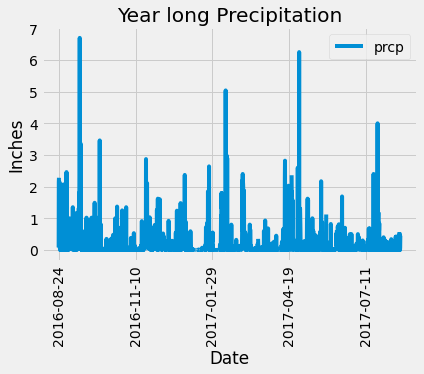

In [62]:
# Use Pandas Plotting with Matplotlib to plot the data
rain_table.plot(title="Year long Precipitation")
plt.xticks(rotation = 90) 
plt.ylabel('Inches')
plt.xlabel("Date")
plt.figure(1)
plt.savefig('Yr Long Prcp')

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_table.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f"Station Count: {station_count}")

Station Count: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = (session.query(Measurement.station, func.count(Measurement.station))
                .group_by(Measurement.station)
                .order_by(func.count(Measurement.station).desc())
                .all())
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_stations = station_count[0][0]

#query station name
station_name = (session.query(Station.name)
               .filter_by(station = active_stations))
station_name = station_name[0][0]
print(f"The most active station is {active_stations}: {station_name}.")

#query lowest temp
lowest_temp = (session.query(Measurement.tobs)
              .filter(Measurement.station == active_stations)
              .order_by(Measurement.tobs.asc())
              .first())
lowest_temp = lowest_temp[0]
print(f"The lowest temperature recordered there is {lowest_temp} degrees Farenheit.")

#query highest temp
highest_temp = (session.query(Measurement.tobs)
              .filter(Measurement.station == active_stations)
              .order_by(Measurement.tobs.desc())
              .first())
highest_temp = highest_temp[0]
print(f"The highest temperature recordered there is {highest_temp} degrees Farenheit.")

#query avg temp
avg_temp = (session.query(Measurement.tobs)
              .filter(Measurement.station == active_stations))
avg_temp = '{0:.3}'.format(avg_temp[0][0])
print(f"The average temperature recordered there is {avg_temp} degrees Farenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The lowest temperature recordered there is 54.0 degrees Farenheit.
The highest temperature recordered there is 85.0 degrees Farenheit.
The average temperature recordered there is 70.0 degrees Farenheit.


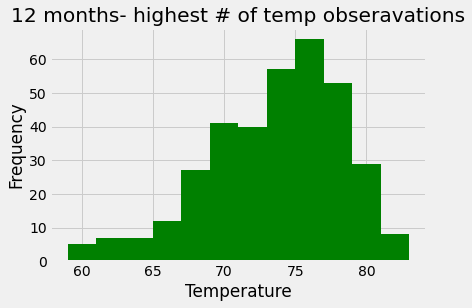

<Figure size 432x288 with 0 Axes>

In [63]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_active_stations = active_stations[0]

active_stations_temp = session.query(Measurement.tobs).\
                        filter(Measurement.date >="2016-08-23").\
                        filter(Measurement.station == "USC00519281").all()
active_stations_temp
len(active_stations_temp)

all_temp = [x[0] for x in active_stations_temp]
all_temp

plt.hist(all_temp, bins=12, color="green")
plt.title("12 months- highest # of temp obseravations")
labels = ['tobs']
plt.ylabel('Frequency')
plt.xlabel("Temperature")
plt.figure(2)
plt.savefig("Statino Histogram")

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2011-02-28','2011-03-05')
trip_temps

[(61.0, 69.75510204081633, 75.0)]

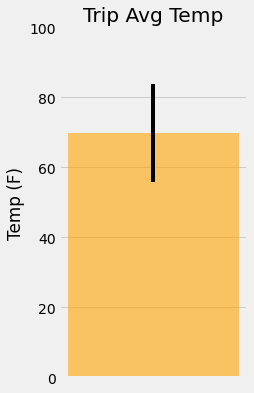

In [72]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(3,6))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'orange', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])
plt.show
plt.savefig("Trip Avg Temp")


In [88]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2011-02-28'
end_date = '2011-03-05'

s = session.query(Station.station,
                 func.sum(Measurement.prcp),
                 Station.name,
                 Station.latitude,
                 Station.longitude,
                 Station.elevation)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

for row in s:
    rain="{0:.2f}".format(row[1])
    print (f"Station: {row[0]}\n Rainfall: {rain}  \n   Location: {row[2]}\n  Elevation: {row[5]}   Latitude:{row[3]}  Longitude:  {row[4]}")
    print()       


Station: USC00518838
 Rainfall: 2.33  
   Location: UPPER WAHIAWA 874.3, HI US
  Elevation: 306.6   Latitude:21.4992  Longitude:  -158.0111

Station: USC00519281
 Rainfall: 2.23  
   Location: WAIHEE 837.5, HI US
  Elevation: 32.9   Latitude:21.45167  Longitude:  -157.84888999999998

Station: USC00519523
 Rainfall: 2.19  
   Location: WAIMANALO EXPERIMENTAL FARM, HI US
  Elevation: 19.5   Latitude:21.33556  Longitude:  -157.71139

Station: USC00514830
 Rainfall: 1.96  
   Location: KUALOA RANCH HEADQUARTERS 886.9, HI US
  Elevation: 7.0   Latitude:21.5213  Longitude:  -157.8374

Station: USC00516128
 Rainfall: 1.45  
   Location: MANOA LYON ARBO 785.2, HI US
  Elevation: 152.4   Latitude:21.3331  Longitude:  -157.8025

Station: USC00513117
 Rainfall: 1.44  
   Location: KANEOHE 838.1, HI US
  Elevation: 14.6   Latitude:21.4234  Longitude:  -157.8015

Station: USC00519397
 Rainfall: 1.38  
   Location: WAIKIKI 717.2, HI US
  Elevation: 3.0   Latitude:21.2716  Longitude:  -157.8168

Stat

TypeError: unsupported format string passed to NoneType.__format__

In [90]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [89]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
